In [58]:
#https://blog.csdn.net/HerosOfEarth/article/details/52347820
def createDataSet(): 
    dataSet = [['youth', 'no', 'no', 1, 'refuse'], 
               ['youth', 'no', 'no', '2', 'refuse'], 
               ['youth', 'yes', 'no', '2', 'agree'], 
               ['youth', 'yes', 'yes', 1, 'agree'], 
               ['youth', 'no', 'no', 1, 'refuse'], 
               ['mid', 'no', 'no', 1, 'refuse'], 
               ['mid', 'no', 'no', '2', 'refuse'], 
               ['mid', 'yes', 'yes', '2', 'agree'], 
               ['mid', 'no', 'yes', '3', 'agree'], 
               ['mid', 'no', 'yes', '3', 'agree'], 
               ['elder', 'no', 'yes', '3', 'agree'], 
               ['elder', 'no', 'yes', '2', 'agree'], 
               ['elder', 'yes', 'no', '2', 'agree'], 
               ['elder', 'yes', 'no', '3', 'agree'], 
               ['elder', 'no', 'no', 1, 'refuse'], ] 
    labels = ['age', 'working', 'house', 'credit_situation'] 
    return dataSet, labels


In [59]:
dataSet,labels = createDataSet()
print(dataSet)
print(labels)

[['youth', 'no', 'no', 1, 'refuse'], ['youth', 'no', 'no', '2', 'refuse'], ['youth', 'yes', 'no', '2', 'agree'], ['youth', 'yes', 'yes', 1, 'agree'], ['youth', 'no', 'no', 1, 'refuse'], ['mid', 'no', 'no', 1, 'refuse'], ['mid', 'no', 'no', '2', 'refuse'], ['mid', 'yes', 'yes', '2', 'agree'], ['mid', 'no', 'yes', '3', 'agree'], ['mid', 'no', 'yes', '3', 'agree'], ['elder', 'no', 'yes', '3', 'agree'], ['elder', 'no', 'yes', '2', 'agree'], ['elder', 'yes', 'no', '2', 'agree'], ['elder', 'yes', 'no', '3', 'agree'], ['elder', 'no', 'no', 1, 'refuse']]
['age', 'working', 'house', 'credit_situation']


In [60]:
from math import log 
class DecisionTree:
    def __init__(self):
        return
    
    def calcShannonEnt(self,dataSet):
        '''
        计算香农熵
        :param dataSet:数据集
        :return: 计算结果
        '''
        numEntries = len(dataSet)
        labelCounts = {}
        for featVec in dataSet: # 遍历每个实例，统计标签的频数
            currentLabel = featVec[-1]
            if currentLabel not in labelCounts.keys(): 
                labelCounts[currentLabel] = 0
            labelCounts[currentLabel] += 1
        shannonEnt = 0.0
        for key in labelCounts:
            prob = float(labelCounts[key]) / numEntries
            shannonEnt -= prob * log(prob,2) # 以2为底的对数
        return shannonEnt
    
    def splitDataSet(self,dataSet, axis, value):
        '''
        按照给定特征划分数据集
        :param dataSet:待划分的数据集
        :param axis:划分数据集的特征
        :param value: 需要返回的特征的值
        :return: 划分结果列表
        '''
        retDataSet = []
        for featVec in dataSet:
            if featVec[axis] == value:
                reducedFeatVec = featVec[:axis]     #chop out axis used for splitting
                reducedFeatVec.extend(featVec[axis+1:])
                retDataSet.append(reducedFeatVec)
        return retDataSet

    def calcConditionalEntropy(self,dataSet, i, featList, uniqueVals):
        '''
        计算X_i给定的条件下，Y的条件熵
        :param dataSet:数据集
        :param i:维度i
        :param featList: 数据集特征列表
        :param uniqueVals: 数据集特征集合
        :return: 条件熵
        '''
        conditionEnt = 0.0
        for value in uniqueVals:
            subDataSet = self.splitDataSet(dataSet, i, value)
            prob = len(subDataSet) / float(len(dataSet))  # 极大似然估计概率
            conditionEnt += prob * self.calcShannonEnt(subDataSet)  # 条件熵的计算
        return conditionEnt
    
    def calcInformationGain(self,dataSet, baseEntropy, i):
        '''
        计算信息增益
        :param dataSet:数据集
        :param baseEntropy:数据集的信息熵
        :param i: 特征维度i
        :return: 特征i对数据集的信息增益g(D|X_i)
        '''
        featList = [example[i] for example in dataSet]  # 第i维特征列表
        uniqueVals = set(featList)  # 转换成集合
        newEntropy = self.calcConditionalEntropy(dataSet, i, featList, uniqueVals)
        infoGain = baseEntropy - newEntropy  # 信息增益，就yes熵的减少，也就yes不确定性的减少
        return infoGain
    
    def calcInformationGainRatio(self,dataSet, baseEntropy, i):
        '''
        计算信息增益比
        :param dataSet:数据集
        :param baseEntropy:数据集的信息熵
        :param i: 特征维度i
        :return: 特征i对数据集的信息增益比gR(D|X_i)
        '''
        return self.calcInformationGain(dataSet, baseEntropy, i) / baseEntropy
    
    def chooseBestFeatureToSplitByID3(self,dataSet):
        '''
                选择最好的数据集划分方式
        :param dataSet:数据集
        :return: 划分结果
        '''
        numFeatures = len(dataSet[0]) - 1  # 最后一列yes分类标签，不属于特征向量
        baseEntropy = self.calcShannonEnt(dataSet)
        bestInfoGain = 0.0
        bestFeature = -1
        for i in range(numFeatures):  # 遍历所有特征
            infoGain = self.calcInformationGain(dataSet, baseEntropy, i)     # 计算信息增益
            if (infoGain > bestInfoGain):  # 选择最大的信息增益
                bestInfoGain = infoGain
                bestFeature = i
        return bestFeature  # 返回最优特征对应的维度
    
    def majorityCnt(self,classList):
        '''
        采用多数表决的方法决定叶结点的分类
        :param: 所有的类标签列表
        :return: 出现次数最多的类
        '''
        classCount={}
        for vote in classList:                  # 统计所有类标签的频数
            if vote not in classCount.keys():
                classCount[vote] = 0
            classCount[vote] += 1
        sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True) # 排序
        return sortedClassCount[0][0]
    
    def createTree(self,dataSet,labels):
        '''
        创建决策树
        :param: dataSet:训练数据集
        :return: labels:所有的类标签
        '''
        classList = [example[-1] for example in dataSet]
        if classList.count(classList[0]) == len(classList): 
            return classList[0]             # 第一个递归结束条件：所有的类标签完全相同
        if len(dataSet[0]) == 1:        
            return majorityCnt(classList)   # 第二个递归结束条件：用完了所有特征
        bestFeat = self.chooseBestFeatureToSplitByID3(dataSet)   # 最优划分特征
        bestFeatLabel = labels[bestFeat]
        myTree = {bestFeatLabel:{}}         # 使用字典类型储存树的信息
        del(labels[bestFeat])
        featValues = [example[bestFeat] for example in dataSet]
        uniqueVals = set(featValues)
        for value in uniqueVals:
            subLabels = labels[:]       # 复制所有类标签，保证每次递归调用时不改变原始列表的内容
            myTree[bestFeatLabel][value] = self.createTree(self.splitDataSet(dataSet, bestFeat, value),subLabels)
        return myTree


In [61]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format="retina" 
#设置出图显示中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False


decisionNode = dict(boxstyle="sawtooth", fc="0.8")
#decisionNode={boxstyle:"sawtooth",fc:"0.8"} #决策节点样式
leafNode=dict(boxstyle="round4",fc="0.8") #叶节点样式

#设置标注箭头格式，->表示由注解指向外，<-表示指向注解，<->表示双向箭头
arrow_args=dict(arrowstyle="->") 
#arrow_args=dict(facecolor="blue",shrink=0.05) #另一种设置箭头格式的方式
"""
输入：字典嵌套格式的决策树
输出：该决策树的叶节点数，相当于决策树宽度(W)
"""
def countLeaf(desicionTree):
    cntLeaf=0
    firstFeatrue=list(desicionTree.keys())[0] #决策树字典的第一个key是第一个最优特征，为什么要提取这个特征呢，因为后面要遍历该特征的属性值从而找个子树
    subTree=desicionTree[firstFeatrue] #取节点key的value，即子树
    
    for key in list(subTree.keys()): #遍历最优特征的各属性值，每个属性对应一个子树,判断子树是否为叶节点
        if type(subTree[key]).__name__=="dict": 
            #如果当前属性值对应的子树类型为字典，说明这个节点不是叶节点，
            #那么就递归调用自己，层层下探找到该通路叶节点，然后向上求和得到该通路叶节点数
            cntLeaf += countLeaf(subTree[key]) #递归
        else:
            cntLeaf += 1
    return cntLeaf

"""
输入：字典嵌套格式的决策树
输出：该决策树的深度(D)
"""
def countDepth(desicionTree):
    maxDepth=0
    firstFeatrue=list(desicionTree.keys())[0] #当前树的最优特征
    subTree=desicionTree[firstFeatrue]
    
    for key in list(subTree.keys()): #遍历最优特征的各属性值，每个属性对应一个子树,判断子树是否为叶节点
        if type(subTree[key]).__name__=="dict": 
            thisDepth = 1+countDepth(subTree[key]) #这里值得认真思考过程，作图辅助思考
        else:
            thisDepth=1
        if thisDepth>maxDepth:
            maxDepth=thisDepth
    return thisDepth
    
#自定义函数，在父子节点之间添加文本信息，在决策树中，相当于标注父结点特征的属性值
#cntPt是子节点坐标，parentPt是父节点坐标
def plotMidText(cntrPt,parentPt,nodeText):
    xMid=(parentPt[0]-cntrPt[0])/2+cntrPt[0]
    yMid=(parentPt[1]-cntrPt[1])/2+cntrPt[1]
    createPlot.ax1.text(xMid,yMid,nodeText)
    
def plotNode(nodeText,centerPt,parentPt,nodeType):
    # nodeTxt为要显示的文本，centerPt为文本的中心点，parentPt为指向文本的点 
    createPlot.ax1.annotate(nodeText,xytext=centerPt,textcoords="axes fraction",\
                            xy=parentPt,xycoords="axes fraction",\
                           va="bottom",ha="center",bbox=nodeType,arrowprops=arrow_args)
    
#自定义函数，是绘制决策树的主力军
def plotTree(decisionTree,parentPt,nodeText):
    cntLeafs=countLeaf(decisionTree)
    depth=countDepth(decisionTree)
    feature=list(decisionTree.keys())[0] #提取当前树的第一个特征
    subDict=decisionTree[feature] #提取该特征的子集，该子集可能是一个新的字典，那么就继续递归调用子集绘制图，否则该特征对应的子集为叶节点
    
    #绘制特征以及该特征属性
    cntrPt=(plotTree.xOff+(1.0+float(cntLeafs))/2.0/plotTree.totalW,plotTree.yOff) #根据整棵树的宽度深度计算当前子节点的绘制坐标
    plotMidText(cntrPt,parentPt,nodeText) #绘制属性
    plotNode(feature,cntrPt,parentPt,decisionNode) #绘制特征
    
    #第一个特征绘制好之后，第二个特征的y坐标向下递减（因为自顶向下绘制，yOff初始值为1.0，然后y递减）
    plotTree.yOff=plotTree.yOff-1.0/plotTree.totalD
    
    #遍历当前树的第一个特征的各属性值，判断各属性值对应的子数据集是否为叶节点，是则绘制叶节点，否则递归调用plotTree()，直到找到叶节点
    for key in subDict.keys(): 
        if type(subDict[key]).__name__=="dict":
            plotTree(subDict[key],cntrPt,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW #从左至右绘制，x初始值较小，然后x递增
            plotNode(subDict[key],(plotTree.xOff,plotTree.yOff),cntrPt,leafNode)
            plotMidText((plotTree.xOff,plotTree.yOff),cntrPt,str(key))
    #在上述递归调用plotTree()的过程中，yOff会不断被减小
    #当我们遍历完该特征的某属性值(即找到该属性分支的叶节点)，开始对该特征下一属性值判断时，若无下面语句，则该属性对应的节点会从上一属性最小的yOff开始合理
    #下面这行代码，作用是：在找到叶节点结束递归时，对yOff加值，保证下一次判断时的y起点与本次初始y一致
    #若不理解，可以尝试注释掉下面这行语句，看看效果
    plotTree.yOff=plotTree.yOff+1.0/plotTree.totalD 

    
#绘图主函数
def createPlot(decisionTree):
    fig=plt.figure(figsize=(10,10),facecolor="white")
    fig.clf() #清空画布
    axprops=dict(xticks=[],yticks=[]) #设置xy坐标轴的刻度，在[]中填充坐标轴刻度值，[]表示无刻度
    # createPlot.ax1为全局变量，绘制图像的句柄，subplot为定义了一个绘图
    #111表示figure中的图有1行1列，即1个，最后的1代表第一个图 
    # frameon表示是否绘制坐标轴矩形 
    createPlot.ax1=plt.subplot(111,frameon=False,**axprops)
    
    plotTree.totalW=float(countLeaf(decisionTree)) #全局变量，整棵决策树的宽度
    plotTree.totalD=float(countDepth(decisionTree))#全局变量，整棵决策树的深度
    plotTree.xOff=-0.5/plotTree.totalW
    plotTree.yOff=1.0
    
    plotTree(decisionTree,(0.5,1.0),'')
    plt.show()

/usr/local/python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


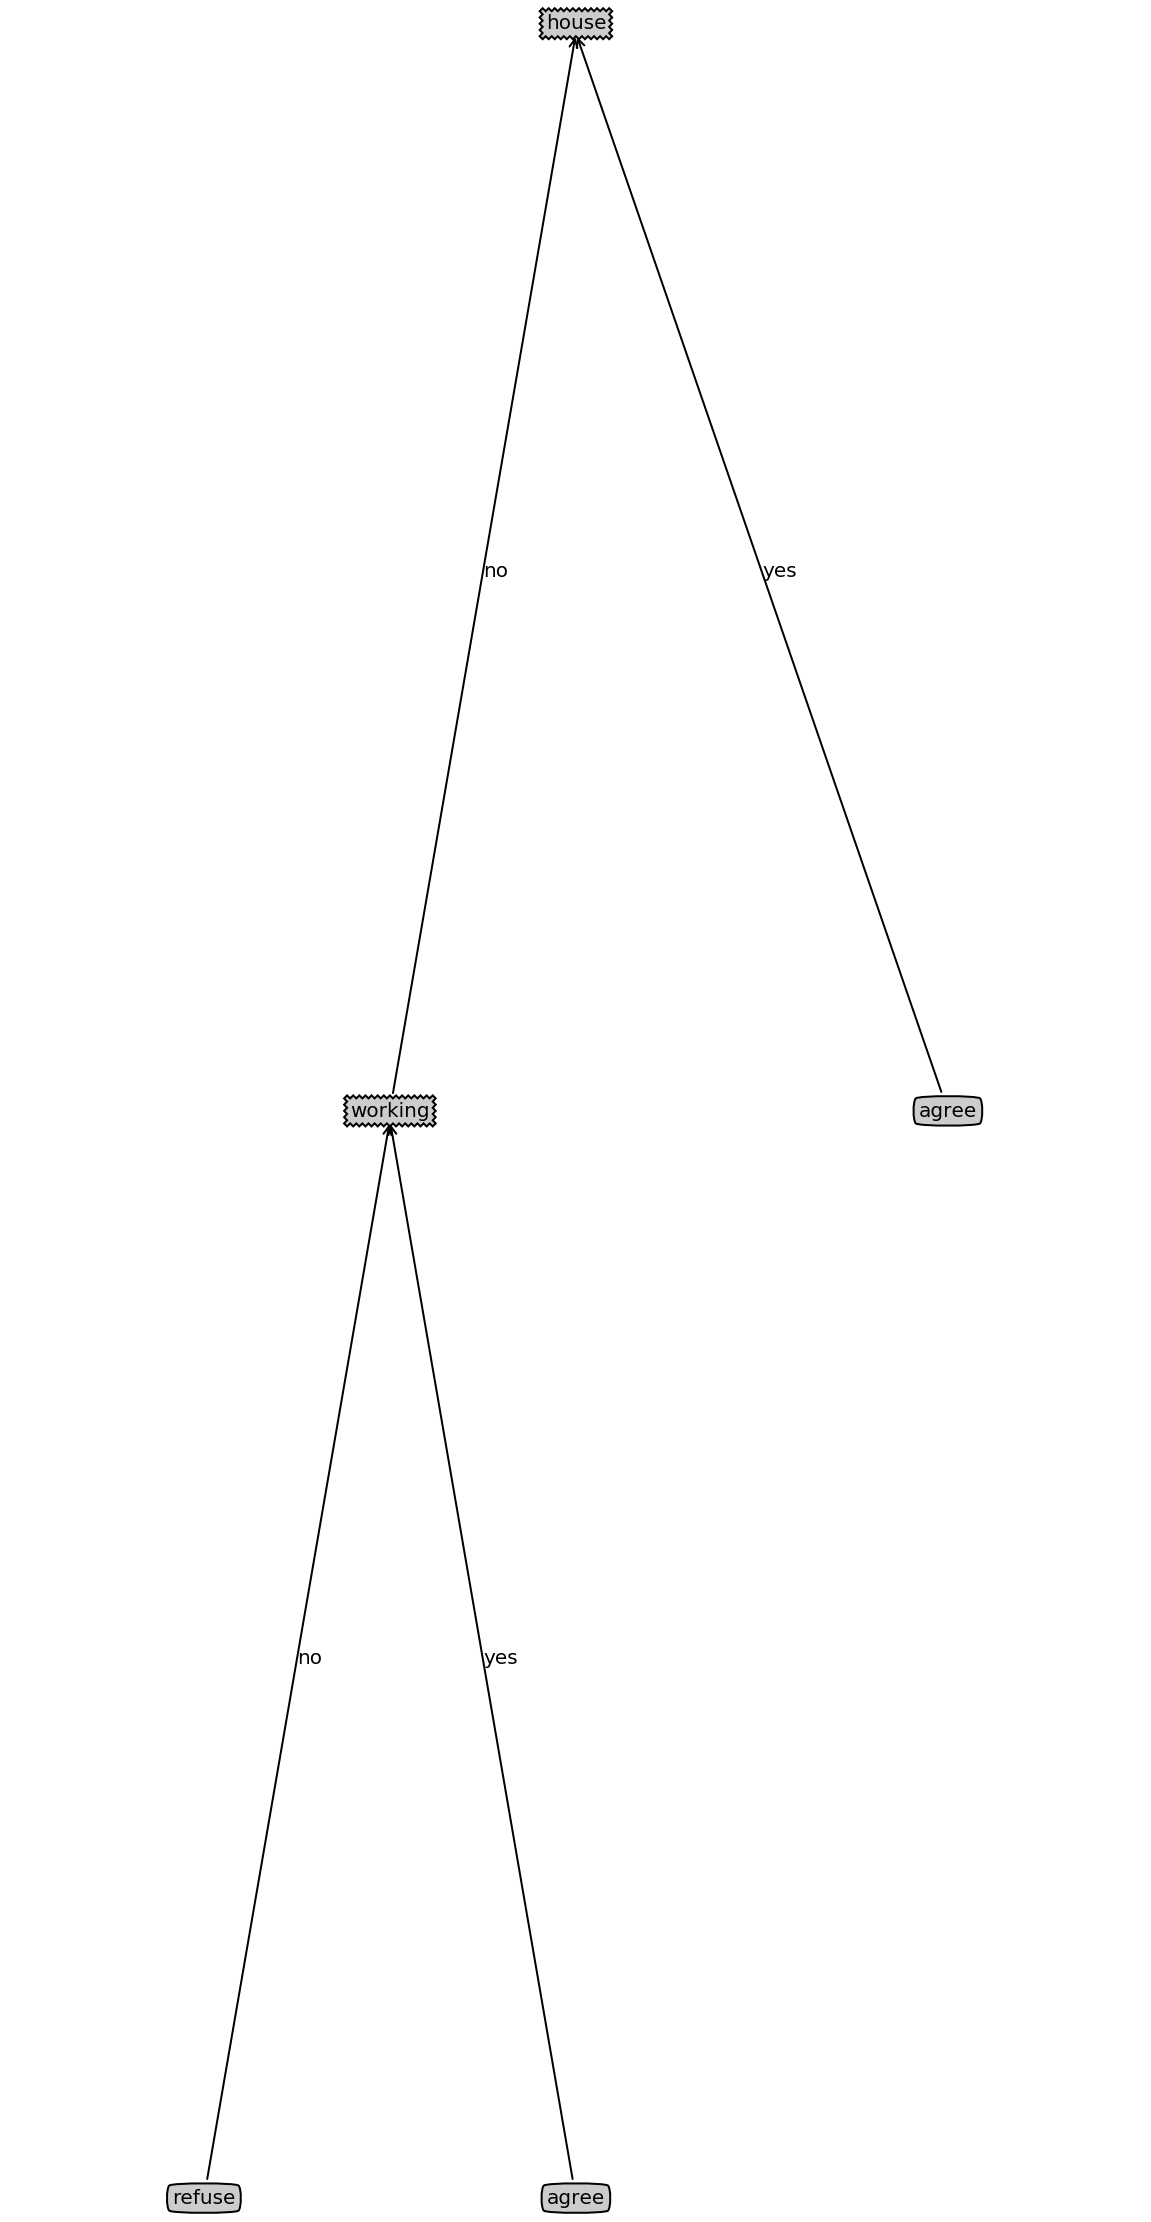

In [62]:
myDecisionTree = DecisionTree()
myDTTree = myDecisionTree.createTree(dataSet,labels)

createPlot(myDTTree)